# INFO 6/3350

## Problem set 1: Clustering and classification

### **Name: Aditya Kakade**  
### **NetID: apk67** 

## Citations:

- For problem 17, I wanted to figure out how to make an array containing the 
permutations of two different lists, in order to test different combinations of 
parameters at the same time. To help with this, I consulted this stack overflow 
post, which helped me use the np.meshgrid function:
https://stackoverflow.com/questions/1208118/using-numpy-to-build-an-array-of-all-combinations-of-two-arrays

- For problem 11, after using SelectKBest to find the top 10 features, I 
couldn't figure out how to get the indices of those features from the select 
object in order to obtain the actual feature names.  To help with this, 
I consulted this stack overflow post, which helped me use the .get_support 
attribute to access these indices and make a mask:
https://stackoverflow.com/questions/39839112/the-easiest-way-for-getting-feature-names-after-running-selectkbest-in-scikit-le

## Instructions for submission

1. Supply your name and NetID above.
1. Submit your completed work via CMS.
1. **Remember to execute every cell of code! Unexecuted code will receive zero credit.** The best way to make sure that everything is in order is to restart your kernel and run all cells immediately prior to submission.
1. Make sure to print all outputs with informative labels.
1. You will submit *both* this fully executed notebook *and* a PDF copy of it. TAs will grade the PDF copy. TAs may refer to or run the code as necessary, but they will not execute it to fill in missing outputs.
1. To generate a PDF version of the completed notebook, export the notebook to HTML, open the resulting HTML file in your browser, and print the rendered HTML to PDF from your browser. You may produce the PDF in other ways, but you are solely responsible for verfiying that it is correct and complete.

# Part 1: Clustering

**The goal of this part of the problem set is to compute and explore three different clusterings of historical court records.**

In this part of the problem set, you'll do the following:
1.  Vectorize a set of historical court records
2.  Perform *k*-Means clustering
    *  Analyze your results
3.  Perform spectral clustering
    *  Analyze your results
4.  Perform and analyze another clustering method of your choice
5.  Reflect on the use of unsupervised methods

## Imports and setup

Hint: Not sure how to get started? Refer to the lecture notes and/or take a look at scikit-learn (sklearn) documentation.

In [94]:
# All import statements belong here
# Do not import packages anywhere else in your code
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.decomposition import TruncatedSVD
from sklearn.feature_extraction.text import TfidfVectorizer
import seaborn as sns
import os
from sklearn.cluster import KMeans, SpectralClustering, AgglomerativeClustering
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import classification_report, accuracy_score, f1_score
from sklearn.feature_selection import SelectKBest, mutual_info_classif
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_validate


## 1. Convenience functions (10 points)

Creating visualizations of your data and pulling sample texts for individual comparison are important parts of assessing the performance of your model. 

**5 points:** Write a function to compare unclustered data with a clustering. Your function should do the following:
1. If the input data contains more than two dimensions, reduce its dimensionality to two using truncated SVD.
1. Initialize a plotting object with `figsize=(12,6)`.
1. Create a left subplot showing the dimension-reduced, unclustered data. Use the `alpha` value supplied in the function call.
1. Create a right subplot containing the same dimension-reduced data and using the supplied cluster labels to set the color of each point. Use the `alpha` value supplied in the function call.
1. Remember to give both the figure and each subplot an informative title!

In [2]:
# Plotting function
def plot_compare(X, labels, title, alpha=0.2):
    '''
    Takes an array of object data, a list of cluster labels, a title string, and an optional alpha value.
    Reduces dimensions to 2 if necessary and plots the clustering with and without coloring by label.
    Returns nothing.
    '''
    if X.shape[1] > 2:
        svd = TruncatedSVD(n_components=2)
        X = svd.fit_transform(X)

    fig, ax = plt.subplots(1,2, figsize=(12, 6))

    ax[0].scatter(X[:,0], X[:,1], alpha = alpha)
    ax[1].scatter(X[:,0], X[:,1], alpha = alpha, c = labels)

    ax[0].set(title = title)
    ax[1].set(title = title)

    plt.show()

Check your plotting function by running the code below.

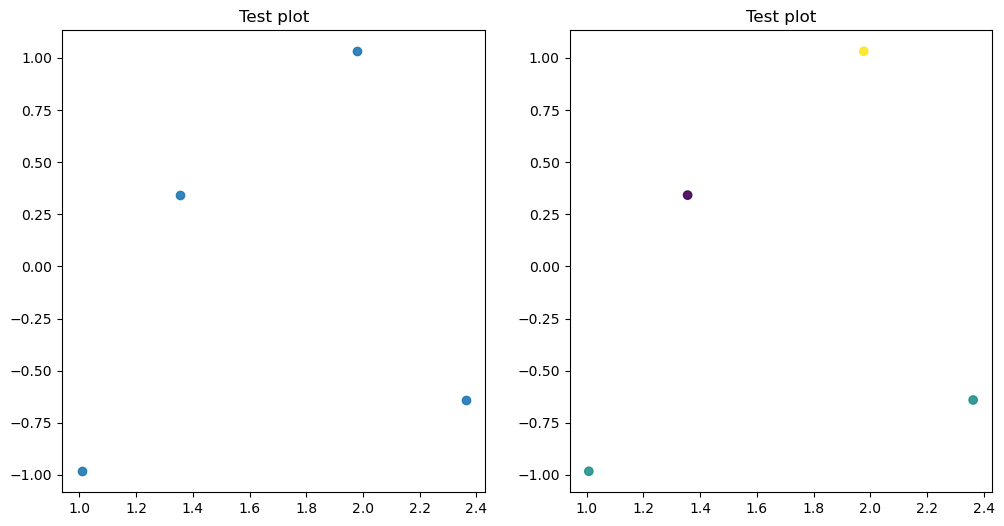

In [3]:
# test plot_compare()
test_data = np.array(
    [[1,1,0], 
     [0,1,1], 
     [2,1,0], 
     [1,2,1]]
)
test_labels = [0,1,2,1]
plot_compare(test_data, test_labels, "Test plot", alpha=0.9)
plt.show()

**5 points:** Write a function, `pull_samples`, to extract sample texts belonging to each label. Your function should do the following:
* Have 3 arguments: `texts` (a list), `labels` (a numpy array), and `n` (the number of samples, default to 3).
* Iterate over each unique label.
* For each label, print the number of texts in the cluster and randomly sample (with replacement) `n` texts to print. (Hint: numpy will be helpful here!)
* Print your results with informative labels, e.g. `"Label:"`, `"Number of texts in this cluster:"`, and `"Sample text:"`. Be sure to print the index position of each sampled text.

In [4]:
# Pull sample texts from each label set
def pull_samples(texts, labels, n=3):
    '''
    Takes a list of texts and an array of labels, as well as number of samples to return per label.
    Prints sample texts belonging to each label.
    '''
    labels_no_duplicates = np.unique(labels)

    for label in labels_no_duplicates:
        count = np.count_nonzero(labels == label)
        indices = np.where(labels == label)[0]
        #print(indices)
        sample = np.random.choice(indices, size = n, replace = True)
        #print(sample)
        print(f"Label: {label}")
        print(f"Number of texts in this cluster: {count}")
        print("Sample text")
        for item in sample:
            print(f"Text at index {item}:")
            print(texts[item])


        




Check your sample-pulling function by running the code below.

In [5]:
# test pull_samples()
test_texts = ["Text one", "Text two", "Text three", "Text four", "Text five", "Text six"]
test_labels = [1,1,1,1,0,0]
pull_samples(test_texts, test_labels)

Label: 0
Number of texts in this cluster: 2
Sample text
Text at index 4:
Text five
Text at index 4:
Text five
Text at index 4:
Text five
Label: 1
Number of texts in this cluster: 4
Sample text
Text at index 3:
Text four
Text at index 0:
Text one
Text at index 1:
Text two


## Old Bailey records

We'll work with a set of 3,090 short text documents from the Old Bailey, the main criminal court of the city of London. These records are a small subset of the almost 200,000 total digitized records collected by [The Old Bailey Proceedings Online](https://www.oldbaileyonline.org/static/Project.jsp).

Our versions of the records have had most names removed. We need to perform some preprocessing, then vectorize the documents. The code below reads the Old Bailey text file and splits it into a list of documents. You should modify the location of the input file as necessary (it's distributed via the course GitHub repo in the `data/old_bailey/` directory).

In [6]:
# Read cases in as a list of strings
#old_bailey_file = os.path.join('..', '..', 'data', 'old_bailey', 'old_bailey.txt')
with open('old_bailey.txt', 'r') as f:
    bailey = [doc for doc in f.read().split('\n\n')] # split on consecutive newlines
print("Total documents:", len(bailey))

Total documents: 3090


## 2. Pre-reflection (10 points, 5 points each)

1. Reflect briefly (2-3 sentences) on what you expect to find in the data. What types of cases do you expect the court to have adjudicated? How many of each type might you expect? What might be the important differences between case types? How cleanly do you expect the different cases to be separated? *Be sure to read the Old Bailey Online documentation linked above before you answer this question.*


Because the Old Bailey Cases date from 1674 all the way to 1913, I expect the court to have adjudicated cases ranging from smaller crimes such as petty theft and small fights in earlier times to larger crimes such as fraud which might have occured with more prevalence later on.  I expect more cases to be along the vein of the 'smaller' crimes not only because those have always been more prevalent in society, but because the documentation states that some crimes (such as sexual ones) were heavily censored.  I expect that the different case types will be well separated when we conduct our analysis, because the language(especially verbs) used to describe different types of crimes tends to vary greatly.

2. Why might you use clustering, an unsupervised method, to study these documents? Answer in 1-2 sentences.

We might use unsupervised clustering because we do not have a good handle on what good case labels might be for our data -- while we can guess at the types of cases, it is unlikely that our guesses will cover and separate the entire dataset properly.  This method will help us identify an initial structure to the data.

## 3. Vectorize (10 points)

The first step is to vectorize the texts to create feature data and labels.

1. Set up a vectorizer as follows, using the given pre-processing function:
* `min_df=2`
* `max_df=0.8`
* `binary=False`
* `norm='l2'`
* `use_idf=True`

2. Explain in a few of your own words how each of the parameters (and their values) affect the vectorizer. It's okay to double check documentation.
3. Vectorize the Old Bailey data, and then print the shape of the output matrix, using an informative label like `"Matrix shape:"`.
4. Print any Old Bailey document along with its features.
5. Make sure that we've retained gendered pronouns (i.e. she/her/hers and he/him/his) in our vectorization using an `assert` statement.

In [7]:
# Custom preprocessing to remove escaped characters in input
def pre_proc(x):
    '''
    Takes a unicode string.
    Lowercases, strips accents, and removes some escapes.
    Returns a standardized version of the string.
    '''
    import unicodedata # it's fine to leave this import here
    return unicodedata.normalize('NFKD', x.replace("\'", "'").replace("\ in\ form", " inform").lower().strip())

In [11]:
# Your code here
bailey_vectorizer = TfidfVectorizer(min_df = 2, max_df = 0.8, binary = False,
                                     norm = 'l2', use_idf = True, preprocessor = pre_proc)
bailey_features = bailey_vectorizer.fit_transform(bailey)
print(f"Output Matrix Shape: {bailey_features.shape}")

print("Example Bailey Document:")
print(bailey[0])

print("Features:")
ex_doc_features = bailey_features[0]
#print(ex_doc_features)
relevant_features_idx = np.nonzero(ex_doc_features)[1]
#print(rel_features_idx)
feature_names = bailey_vectorizer.get_feature_names_out()
rel_feature_names = feature_names[relevant_features_idx]
print(rel_feature_names)
#assert that gendered pronouns are present
assert(
  "she" in feature_names and
  "her" in feature_names and
  "hers" in feature_names and
  "he" in feature_names and
  "him" in feature_names and
  "his" in feature_names
)


Output Matrix Shape: (3090, 8638)
Example Bailey Document:
was indicted for feloniously breaking and entering the dwelling-house of and , about three o'clock in the afternoon of the 4th of January , at St. James, Westminster ( and others being therein), and stealing, one coat, value 18 s., and one sheet, value 2 s., the goods of the said . The prisoner pleaded, GUILTY . - DEATH . Aged 45. Before Mr. Recorder.
Features:
['feloniously' 'breaking' 'entering' 'dwelling' 'house' 'about' 'three'
 'clock' 'afternoon' '4th' 'january' 'at' 'st' 'james' 'westminster'
 'others' 'being' 'therein' 'one' 'coat' '18' 'sheet' 'goods' 'said'
 'pleaded' 'death' 'aged' '45' 'before' 'mr' 'recorder']


**2:**


The min_df parameter means the vectorizer will not include terms that appear in less than 2 documents in the list of features.  The max_df parameter does the opposite -- if a term appears in more than 80% of the Bailey documents, it will also not be included as a feature.  Setting the binary parameter to false means that terms who have non-zero counts will not have term frequency in tf-idf set to 1 -- the actual term frequency will be used.  Setting the norm parameter to l2 applies l2 normalization to each document's vector -- all values^2 will sum to 1.  Finally, setting use_idf to true means that inverse document frequency is used by the vectorizer -- terms that are less widely used will be upweighted relative to those that aren't.

## 4. Perform *k*-Means clustering (10 points)

Perform *k*-Means clustering with `n_clusters=3` on your vectorized data.

Specifically, you must:
1. Perform the clustering.
2. Print the shape of your label vector (it should match the number of documents in the input data set).
3. Plot the resulting clustering using the `plot_compare` function you wrote above.

You should be able to accomplish these tasks in a few lines of code.

Label Vector Shape:
(3090,)


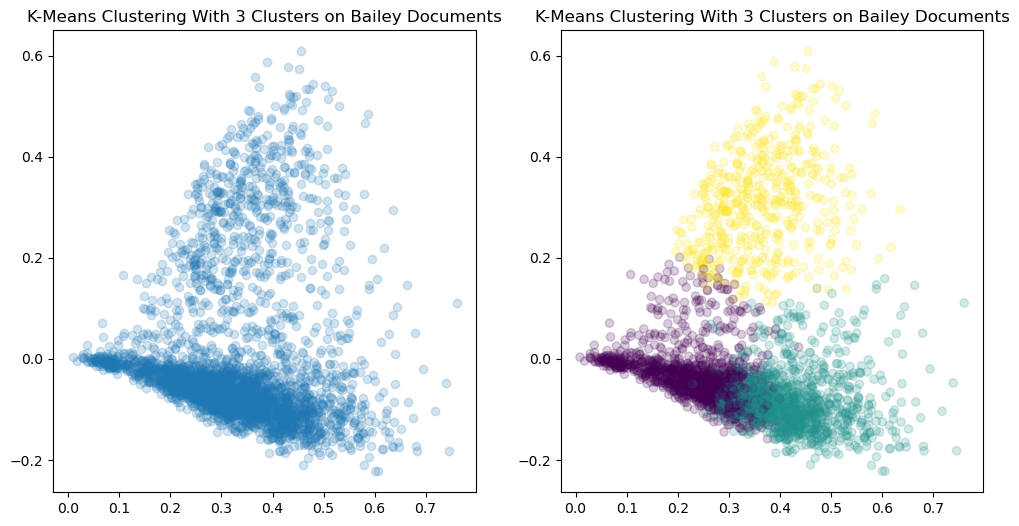

In [16]:
# k-Means clustering with n_clusters = 3
labels_k_3 = KMeans(n_clusters=3, random_state = 42).fit_predict(bailey_features)
print(f"Label Vector Shape:\n{labels_k_3.shape}")
plot_compare(bailey_features, labels_k_3, "K-Means Clustering With 3 Clusters on Bailey Documents")


## 5. Perform and analyze *k*-Means clustering with five clusters (5 points total)

**Perform *k*-Means clustering with 5 clusters instead of 3.** Make sure to print the shape of the label vector and plot the clustering (3 points).

Label Vector Shape:
(3090,)


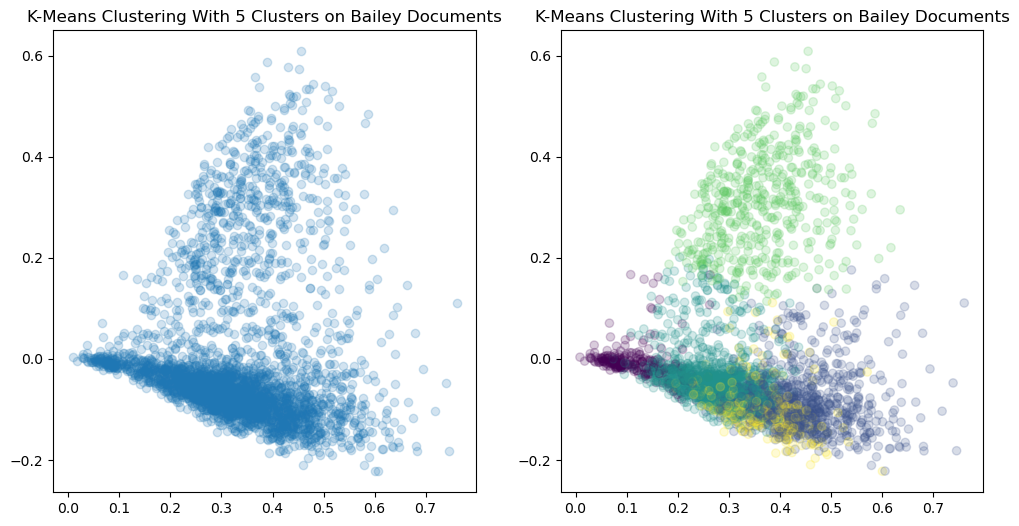

In [17]:
# k-Means clustering with n_clusters = 5
labels_k_5 = KMeans(n_clusters=5, random_state = 42).fit_predict(bailey_features)
print(f"Label Vector Shape:\n{labels_k_5.shape}")
plot_compare(bailey_features, labels_k_5, "K-Means Clustering With 5 Clusters on Bailey Documents")

**Reflect on the different results between 3 clusters and 5 clusters (2 points).**  

 Compare the visualizations between 3 and 5 clusters. How did the clusters change? Did one of the clusters remain the same? Or are the results entirely different? Explain what you've noticed in 1-2 sentences.

When going from 3 clusters to 5 clusters, the clusters become less defined, especially for documents below the 0.0 mark on the y-axis.  One of the clusters -- the one towards the top of the scatterplot that is yellow in the plot with 3 clusters and green in the plot with 5 clusters -- does remain the same.  For the other clusters though, it appears that increasing the number of clusters to five has resulted in the K-means algorithm splitting more natural clusters into ones with no meaningful underlying structure and relationships.

## 6. Analyze *k*-Means clustering results (15 points) 

**Use the `pull_samples` function you wrote above to examine five documents from each cluster (when `n_clusters = 3`) (5 points).**

In [18]:
# Pull samples here
pull_samples(bailey, labels_k_3, 5)

Label: 0
Number of texts in this cluster: 1426
Sample text
Text at index 1146:
and were indicted for stealing, on the 12th of November , one copper boiler, value 5 s. , the goods of . . I keep the Flying Horse public-house, Chelsea ; the copper boiler was in my back yard; I missed it on the 13th of November; I had seen it about four o'clock in the afternoon of the 12th. I found it on the 14th at Mr.. Purcell's. . I am a constable of Bow-street.. On the 13th of November Mr. Vinall sent for me, and the next day I took Hill in the New-road, near Vinall's, he denied it; I took Collyer, he denied it also; I took him to Mr. Vniall's; he then said he did take it, and that Hill sold it in Ellis-street, in Sloane-street, I went there and found it. . I am a dealer in marine stores, and live in Ellis-street, Sloane-street. Hill brought me the copper to sell, on the 12th of November, at a quarter past six o'clock, I gave him 4 s. 7 d. for it, it weighed 17 lbs. it had no lid. I asked him no partic

**Write a paragraph analyzing your results (10 points).** 

In your analysis, discuss whether you can make sense of the clusters. Do the cases look like what you expected? Do the calculated clusters strike you as meaningfully distinct? Do you think justice was done in the cases you examined? Anything else that stands out?

In looking at all the cases regardless of cluster, they do look like what I expected when it comes to type of crime -- most appear to be relating to the theft of household items like clothing, as well as money.  I was not expecting the cases to have such a standardized format, but it appears they do.  Almost all of the cases in the sample include the crime, then the date, then the items stolen or object associated with the crime, followed by a testiony and sentence.  I can't seem to distinguish why each sample was clustered together, however.  It seems that all 3 clusters contain a distribution of crimes (from theft to forgery) and in the case of theft, there doesn't seem to be a common theme to the items stolen from cluster to cluster.  Even the testimonies seem to be distributed across all clusters, rather than having specific themes in one.  In the cases examined, I don't think justice was done.  While I don't condone any of the crimes committed, many of the punishments for theft seem very extreme.  For example, being sentenced to 20 years for stealing a coat seems excessive.

## 7. Spectral clustering (30 points)

*k*-Means is just one approach to clustering. Here, you'll produce produce a **spectral clustering**, with cosine similarity, as a point of comparison. You may want to consult the scikit-learn [SpectralClustering](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.SpectralClustering.html) documentation.

You must:

1. Set up a `SpectralClustering` object with `n_clusters=3` and `affinity='precomputed'`
1. Calculate the pairwise `cosine_similarity` matrix on your vectorized input data
1. Compute a spectral clustering on the cosine similarity matrix, storing the output labels in a variable named `y_spectral`
1. Print the shape of your output label vector
1. Plot your results using your `plot_compare` function
1. Pull and print 5 sample cases belonging to each cluster using the `pull_samples` function
1. Discuss the results of your spectral clustering, both on their own and in comparison to the *k*-Means results. About an honest paragraph should be sufficient.

Label Vector Shape:
(3090,)


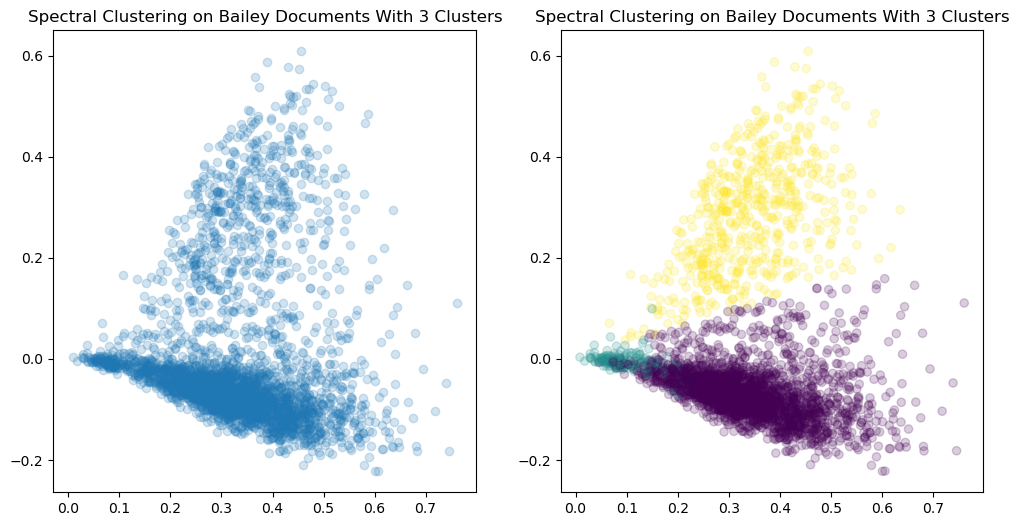

Label: 0
Number of texts in this cluster: 2348
Sample text
Text at index 2752:
was indicted for stealing, on the 23d of November , 3 pairs of shoes, 2l. 8s. , the goods of , his master. . I am in the employ of Mr. John Bann, shoemaker , of New Bond-street - the prisoner was in his employ - he was a blocker . On the 23d of November I was directed by another shopman to look into the pocket of his coat, which hung against the wall - I put my hand in, took out one shoe, and asked the prisoner if he knew any thing about it - he said, No - I said, "Do not deny it, for you know the fellow is in your pocket;" he said, "It is all right;" he took the other shoe out of his pocket, and told me to say nothing about it. . I am shopman to a pawn broker, the prisoner came to our shop on the 24th of October, and pledged a pair of shoes for 4s. . I am shopman to Mr. Aldous, a pawnbroker. I have a pair of shoes which the prisoner pawned. . I am an officer. I took the prisoner, and found these two duplica

In [21]:
# Your spectral clustering code
spectral_obj = SpectralClustering(n_clusters = 3, random_state = 42, affinity = "precomputed")
p_cos_sim = cosine_similarity(bailey_features)
y_spectral = spectral_obj.fit_predict(p_cos_sim)
print(f"Label Vector Shape:\n{y_spectral.shape}")
plot_compare(bailey_features, y_spectral, "Spectral Clustering on Bailey Documents With 3 Clusters")
pull_samples(bailey, y_spectral, 5)

**Reflection:**

The cluster of documents towards the top of the plot (yellow) remained similar to the one identified by K-means.  The splitting of the remaining data points was very different, however.  The blue cluster is similar to the one in the same location that was identified by K-means with 5 clusters, but much smaller than the corresponding cluster in the K-means with 3 clusters.  The remaining cluster (to the right of x = 0.1)  is much larger than it was in K-means.  This shows that the boundary for documents with y-values less than ~0.4 changed when spectral clustering was used.  Looking at the samples themselves, I think I am able to detect some themes.  Cases with Label 2 appear to concern females to a higher degree in the descriptions, using many instances of 'she', 'her', and 'woman.'  The cases from Label 1 appear to include currency in the items that were stolen.  The cases from Label 0 appear to primarily concern men.  While one of the clusters was similar to that from K-Means with 3 clusters, I think that spectral clustering made the relation between the cases in each cluster clearer to me -- at least relative to eachother.

## 8. Any other clustering method (25 points)

Perform the same steps as in the *k*-Means and spectral clustering cases (set up with appropriate options, compute labels, print label vector dimensions, plot, pull samples, and discuss results), but using a different clustering method from among [those offered by scikit-learn](https://scikit-learn.org/stable/modules/clustering.html#clustering). Say something brief about why you chose the method you did as part of your discussion.

Note: You'll want to pay particular attention to data input formats and to any key parameters of your chosen clustering method. Just as spectral clustering required an affinity (similarity) matrix as input, some methods want a precomputed distance or similarity matrix as input. Others are very sensitive to options (like epsilon in DBSCAN). Work with care and note in your discussion any choices that you feel were important.

Label Vector Shape:
(3090,)


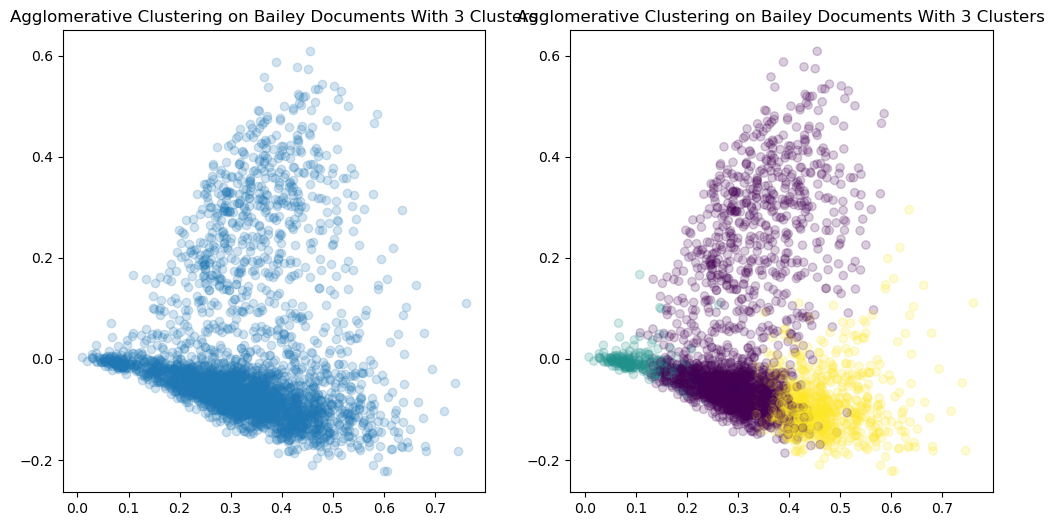

Label: 0
Number of texts in this cluster: 2128
Sample text
Text at index 1893:
was indicted for stealing, on the 24th of September , a watch, value 40 s.; two seals, value 20 s.; two keys, value 6 d., and a ribbon, value 2 d., the goods of , from his person . . I am servant to a gentleman in Cavendish-square. On the 24th of September, about eleven o'clock at night, I was in Regent-street, and as I crossed Oxford-street , was accosted by a female, who asked for drink. I passed on - she kept by my side, and a few yards further, I saw the prisoner sitting on some rubbish - the woman went up to her and said something, the prisoner instantly sprang from the rubbish, attempted to cross me, and at the same time snatched my watch from my fob. I instantly seized and accused her of it - she positively denied it, struggled, and by some means got down on the pavement. I looked to see that she did not hand it to the other; the watchman came up, and I gave her in charge - she was then on the ground;

In [28]:
# Your code here
agglom_obj = AgglomerativeClustering(n_clusters = 3, linkage = 'average')
y_agglom = agglom_obj.fit_predict(p_cos_sim)
print(f"Label Vector Shape:\n{y_agglom.shape}")
plot_compare(bailey_features, y_agglom, "Agglomerative Clustering on Bailey Documents With 3 Clusters")
pull_samples(bailey, y_agglom, 5)


I chose Agglomerative Clustering for this question.  I chose a hierarchical clustering method because I felt it would be useful for a dataset I knew very little about, in terms of documents' relations with eachother.  Starting documents in their own clusters and greedily grouping them with similar clusters seems like it would be good for this.  The clusters ended up being very different from those seen in K-means and Spectral.  Rather than having a top cluster for values above y ~ 0.3, and then a separation of the remaining points, the points appear to be separated by diagonal lines that result in two smaller clusters and one very large one.  When looking at the samples, I find it difficult to find any themes from cluster to cluster, whereas with Spectral clustering, I felt that I could detect some underlying commonality.

## 9. Reflect on clustering methods in general (10 points)
You've now tried multiple clustering methods on a dataset of historical court records. **Consider the following questions, and respond in 1-2 paragraphs:** 

* What did you learn about the court records by using clustering as a method? 
* How might clustering be useful for studying literature? 
* What are the advantages of clustering methods? Do you foresee any disadvantages or limitations to them? 

By using clustering as a method, I was able to gain insight into some of the patterns that the court records followed. For example, I was able to learn that the cases spanned crimes from theft of material goods and money to fraud to more serious ones such as rape.  The clusters also seemed to reveal underlying patterns with the gender of the victim or criminal.  Overall, clustering was able to reveal that the court records followed a pattern that may have changed over time, in line with what the documentation stated about the evolution of the court from the 1600s to the 1900s.

Clustering can be useful for studying literature because it makes it easier for the researcher to identify trends and patterns.  With large amounts of text, it is almost impossible to read through manually and identify which texts relate to others, and what they should be labeled as.  Since clustering is unsupervised, it is able to do some of this inital work for the reseracher.  The advantages of clustering methods include the fact that pre-determined labels do not need to be assigned, and the fact that the number of clusters can be changed with each iteration of the model.  This enables the model to be fine tuned to the data, to help ensure that clusters are meaningful.  Disadvantages do include the fact that there does not seem to be a surefire way to identify which clustering method will work best for a dataset.  In addition, the clusters might not appear to have a structure that is meaningful to the dataset or research question at hand, and it requires some experimentation to find an appropriate amount of clusters that are not covering too many commonalities but also not making arbitrary splits.

# Part 2: Classification

**The goal of this part of the problem set is to implement and explore different algorithms for classifying novels into the genres *mystery* or *science fiction*.**

In this part, you'll do the following:
1. Load feature data containing unigram token counts for mystery and science fiction books.
2. Perform classification using logistic regression and *k*-nearest neighbors.
3. Perform some other classification methods.
4. Compare classification methods and improve performance by modifying parameters.
4. Reflect on the use of supervised methods.

## The dataset

The dataset used in this part of the problem set is derived from [data released by Ted Underwood](https://github.com/tedunderwood/horizon/tree/master) in support of his book, _Distant Horizons_. The original files contain normalized unigram and bigram word counts for every text in the corpus, but we retained only the unigram data for mystery and science fiction novels for your text-mining convenience. 

There are a total of 316 texts, of which 160 are mystery and 156 are science fiction. Each text's genre is indicated in the supplied feature file.

## 10. Loading and examining the data (15 points)

Underwood released the unigram and bigram features in a bag-of-words format that's a little tricky to process. We've transformed the data into a CSV file that you can load and manipulate more easily.

**5 points:** Load the feature data from `genre-features.csv.gz` into a pandas dataframe (this file is distributed via the course GitHub repo, in the `data/mystery-scifi/` directory). The features are length-normalized (per 100,000 words) token unigram counts for the 10,000 most frequently occurring token unigrams in the corpus. Observations are indexed by `docid`, so make sure this column is set as the index of your dataframe.

The feature data also has a column, `GENRE LABEL`, that contains the genre label for each book. Remove this column from the dataframe and assign it to a new variable. You should now have two variables, one that contains only feature data and one that contains the true labels for the observations.

After you are done, print the shapes of your feature matrix and your labels. They should be `(316, 10000)` and `(316,),` respectively.

In [39]:
# Read and process the feature data

mystery_scifi_init = pd.read_csv("genre-features.csv.gz", index_col = 'docid')

genre_label = mystery_scifi_init['GENRE LABEL']

mystery_scifi = mystery_scifi_init.drop(columns = ['GENRE LABEL'])

print(f"Feature Matrix Shape: {mystery_scifi.shape}")
print(f"Labels Shape: {genre_label.shape}")

Feature Matrix Shape: (316, 10000)
Labels Shape: (316,)


C:\Users\adika\AppData\Local\Temp\ipykernel_39736\834255309.py:3: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  mystery_scifi_init = pd.read_csv("genre-features.csv.gz", index_col = 'docid')


Let's print the first five rows of the dataframe to see what the data look like.

**2 points:** Display the first five rows of the feature matrix.

In [40]:
# Display the first 5 rows of feature data

mystery_scifi.head(5)

,the,and,to,a,of,i,he,in,was,it,...,perplexity,pension,mop,manoeuvring,thaler,chew,adviser,mating,splintered,rasped
docid,,,,,,,,,,,,,,,,,,,,,
10008,6497.223555,2723.315281,2749.023103,2066.908891,3470.555974,2944.402550,903.201481,1372.797697,1477.342840,1012.888188,...,0.000000,0.0,0.000000,1.713855,0.0,0.000000,0.0,0.0,0.0,0.000000
10053,6170.935463,3282.842192,2631.047462,1885.614615,3525.199670,3009.272010,1022.675112,1187.918847,1276.048839,984.118241,...,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000
10065,4417.829167,2695.290148,1827.114698,2444.703143,1542.984550,1144.413094,2168.465500,1258.854403,1302.263176,880.014207,...,0.000000,0.0,1.973126,1.973126,0.0,5.919378,0.0,0.0,0.0,0.000000
10083,7465.883056,3090.447256,2441.727264,1896.354219,3679.400339,676.113159,1831.606734,1367.168045,1354.716605,1123.119833,...,3.735432,0.0,0.000000,2.490288,0.0,0.000000,0.0,0.0,0.0,0.000000
10090,6227.735459,1995.184523,1864.237338,2064.178201,2203.573591,2740.034638,981.399868,1253.150477,1871.277509,1419.298517,...,0.000000,0.0,0.000000,1.408034,0.0,0.000000,0.0,0.0,0.0,2.816068


**5 points**: Plot the feature data using truncated SVD to reduce dimensionality to two. Color the observations by genre. Your plot should include an informative title and legend.

Text(0, 0.5, 'Dimension 2')

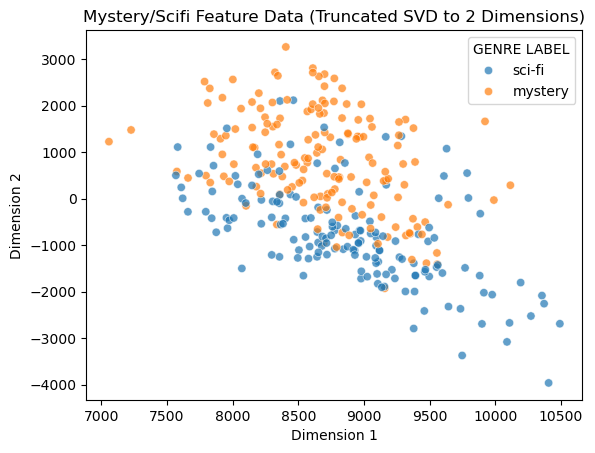

In [63]:
# Plot the feature data
svd = TruncatedSVD(n_components=2)
X = svd.fit_transform(mystery_scifi)

sns.scatterplot(x = X[:,0], y = X[:,1], hue = genre_label, alpha = 0.7)
plt.title("Mystery/Scifi Feature Data (Truncated SVD to 2 Dimensions)")
plt.xlabel("Dimension 1")
plt.ylabel("Dimension 2")

**3 points:** If we want to know how well a classifier performs on our data set, we need to have a baseline to which to compare it. The simplest such measure is to assign the most common label to every observation in the dataset. Calculate and print baseline accuracy and F1 scores using this naive method.

In [67]:
# Calculate baseline performance
most_common_label = genre_label.mode()
comm_label_pred = np.full((316,), most_common_label[0])
#print(comm_label_pred)
print(f"Baseline Accuracy: {accuracy_score(genre_label, comm_label_pred)}")
print(f"Baseline F1 Score: {f1_score(genre_label, comm_label_pred, average = 'weighted')}")

Baseline Accuracy: 0.5063291139240507
Baseline F1 Score: 0.3403893202850761


## 11. Selecting features (10 points)

Before getting started with the classification task, there are some things we need to do.

1. We have _a lot_ of features. Comment on why this might be an issue. **(4 points)**
2. Select the 10 **most** useful features for our next steps. You will **use these selected features for the remaining problems unless instructed to do otherwise**. You may use any reasonable and appropriate method to select these features, but they should be token-count-based features from the original data, not mathematical reductions via PCA, SVD, UMAP, etc. **(3 points)**
3. Print out the features to see what words they are. How did you select these features? Are they what you would expect, given what you know about the genres of mystery and science fiction? Write two observations. **(3 points)**

**1:**


Having this many features might cause the curse of dimensionality.  This means that the distance between data points (texts) might become too great for the model to efficiently and properly classify their genre.  In addition, having too many features might also cause overfitting -- it is very unlikely that all of the features are actually relevant to the genre classification task at hand.  As a result, the model might fit to irrelevant features in the data, causing it to perform badly in a context where the input data is different.


In [112]:
# Select ten useful features
ten_features = SelectKBest(score_func=mutual_info_classif, k = 10).fit(mystery_scifi, genre_label)
mask = ten_features.get_support()
ten_feature_names = mystery_scifi.columns[mask]
mystery_scifi_ten = mystery_scifi[ten_feature_names]
print(ten_feature_names)

Index(['their', 'police', 'earth', 'human', 'power', 'murder', 'o'clock',
       'detective', 'murderer', 'murdered'],
      dtype='object')


**Observations:**

I selected the features using the SelectKBest function that we covered in lecture.  Looking at the feature output, they do align with what I was expecting.  The first thing I observe is the fact that there are three features that are variations of the word murder -- this is not surprising though, as I feel many mysteries have some reference to a murder crime.  Another observation is the inclusion of the word 'their' as an important feature -- I'm not entirely sure how this could be used to differentiate between mystery and sci-fi, since it is such a common adjective.  All of the other features do make sense to separate the two genres, though.

## 12. Classification with logistic regression and *k*-neighbors (10 points)

Let's perform classification with the logistic regression and *k*-neighbors algorithms.
1. Take a look at the [documentation](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_validate.html) for `cross_validate()`. 
2. Perform cross validation using the two given classifiers and score their performance on accuracy, precision, recall, f1, f1 (macro averaged), and f1 (micro averaged).
3. Display your scores in an easily legible format (there's some example code that you can use for this, but you may use any format that's easy(ish) to read and digest).

**N.B.** You'll probably encounter an initial error in your cross validation scoring. This has to do with the format of the values in your genre labels. Consider how best to overcome this problem.

In [155]:
# Classifers to test
classifiers = {
    'kNN': KNeighborsClassifier(),
    'Logit':LogisticRegression(max_iter=1000)
}

# Your code here

genre_label_num = genre_label.replace({'mystery' : 1, 'sci-fi' : 0})

kNN_scores = cross_validate(classifiers['kNN'], mystery_scifi_ten, genre_label_num, 
                            scoring = ('accuracy', 'precision', 'recall', 'f1', 'f1_macro', 'f1_micro'))
LR_scores = cross_validate(classifiers['Logit'], mystery_scifi_ten, genre_label_num,
                           scoring = ('accuracy', 'precision', 'recall', 'f1', 'f1_macro', 'f1_micro'))
#print(kNN_scores)
#print(LR_scores)

C:\Users\adika\AppData\Local\Temp\ipykernel_39736\112298389.py:9: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  genre_label_num = genre_label.replace({'mystery' : 1, 'sci-fi' : 0})


In [156]:
# Examine the performance of our simple classifiers
# Freebie function to summarize and display classifier scores
# You may reimplement as you see fit
def compare_scores(scores_dict):
    '''
    Takes a dictionary of cross_validate scores.
    Returns a color-coded Pandas dataframe that summarizes those scores.
    '''
    df = pd.DataFrame(scores_dict).T.map(np.mean).style.background_gradient(cmap='RdYlGn')
    return df

In [157]:
# Compare scores here
compare_scores({'kNN Scores' : kNN_scores, 'Logit Scores' : LR_scores})

,fit_time,score_time,test_accuracy,test_precision,test_recall,test_f1,test_f1_macro,test_f1_micro
kNN Scores,0.013085,0.044050,0.942857,0.935758,0.956250,0.945106,0.942674,0.942857
Logit Scores,0.060586,0.028528,0.952381,0.951324,0.956250,0.952587,0.952285,0.952381


## 13. Explain the classification results for one classifier (9 points)
For **one** classifier, explain what the `test_precision`, `test_recall`, and `test_f1` results mean, in relationship to our corpus of mystery and science fiction books. What do the results of each metric tell us about how the classifier handles the classification task as it pertains to the books we are working on? Make sure to go beyond definitions you might find for each of these measures, and explain the meaning of the numbers you've calculated for each metric in context (1-2 sentences for each metric). 

**Results for kNN Classifier**

test_precision:
- This result means that out of the texts that our model predicted to be mysteries (what I set as the positive label), around 93.6% of them were actually mysteries -- the rest were scifi texts that were incorrectly labeled as mysteries, meaning our model falsely identifies a text as a mystery about 6.4% of the time.  In the context of assigning books to a genre, this performance doesn't seem to be terrible!

test_recall:
- This result means that out of all of the texts in the provided dataset that were actually mysteries, our model correctly identified around 95.6% of them as being mysteries.  For the other 4.4%, it incorrectly predicted that they were sci-fi texts.

test_f1:
- This result balances both precision and recall -- it represents how well our model handles the tradeoff between correctly identifying texts as mysteries with high confidence but missing actual mysteries, and correctly identifying a large number of the mysteries but also mislabeling sci-fi texts as mysteries.  Because the f1 score is around 94.5, it measn our model does a decent job at this, and is able to distinguish between the two types of texts in most cases.

## 14. Add results from three more classifiers (15 points)

1. **6 points:** Set up three new classifiers -- decision tree, random forest, and multinomial naïve Bayes -- from Scikit-learn. Use **default** parameters only (that is, do not set any classifier parameters yourself).
2. **6 points:** Cross-validate the three new classifiers and save the scores.
3. **3 points:** As above, display the scores of all five classifiers.

Note: this shouldn't take very long to run (only a few seconds).

In [158]:
# More classifiers here
classifiers_14 = {
    'DT': DecisionTreeClassifier(),
    'RF':RandomForestClassifier(),
    'NB': MultinomialNB()
}

DT_scores = cross_validate(classifiers_14['DT'], mystery_scifi_ten, genre_label_num, 
                            scoring = ('accuracy', 'precision', 'recall', 'f1', 'f1_macro', 'f1_micro'))
RF_scores = cross_validate(classifiers_14['RF'], mystery_scifi_ten, genre_label_num,
                           scoring = ('accuracy', 'precision', 'recall', 'f1', 'f1_macro', 'f1_micro'))
MNB_scores = cross_validate(classifiers_14['NB'], mystery_scifi_ten, genre_label_num,
                           scoring = ('accuracy', 'precision', 'recall', 'f1', 'f1_macro', 'f1_micro'))

compare_scores({'kNN Scores' : kNN_scores, 'Logit Scores' : LR_scores, 
                'Decision Tree Scores' : DT_scores,
                'Random Forest Scores' : RF_scores,
                'Multinomial NB Scores' : MNB_scores})

,fit_time,score_time,test_accuracy,test_precision,test_recall,test_f1,test_f1_macro,test_f1_micro
kNN Scores,0.013085,0.044050,0.942857,0.935758,0.956250,0.945106,0.942674,0.942857
Logit Scores,0.060586,0.028528,0.952381,0.951324,0.956250,0.952587,0.952285,0.952381
Decision Tree Scores,0.009744,0.022517,0.911260,0.930008,0.893750,0.908811,0.911006,0.911260
Random Forest Scores,0.257907,0.032945,0.955605,0.957227,0.956250,0.956017,0.955563,0.955605
Multinomial NB Scores,0.000000,0.015062,0.955605,0.967918,0.943750,0.955448,0.955598,0.955605


## 15. Compare the unoptimized performance of the five classifiers (10 points)

How would you summarize the performance of the five classifiers prior to any optimization? Consider classification performance relative to one another and to baseline, as well as computation time. Describe the results in 3-4 sentences. 

All of the classifiers performed significantly better than the baseline performance.  While almost all were around 0.95 for F1 score and accuracy, the decision tree classifier did lag behind at around 0.90 for both.  The decision tree classifier did take the second least amount of time though, being beat only by Multinomial Naive Bayes.  kNN, Logistic Regression, and Random Forest had the same exact performance for recall and were the best out of all 5 models, suggesting they were the strongest at identifying mysteries from the collection of texts that were actually mysteries.  The Random Forest had the highest F1 score of all models though, suggesting that it provided the best balance between precision and recall.

## 16. Change parameters for the decision tree classifier (10 points; 5 points for each part)
In the prior question, you used default parameters for each of the classifiers. For the decision tree classifier, when the `max_depth` parameter isn't specified, the "nodes are expanded until all leaves are pure or until all leaves contain less than `min_samples_split` samples." 

**5 points**: Compare the decision tree classifier's performance at various tree depths:
* Initialize decision tree classifiers with a `max_depth` of `None`, `100`, `20`, `10`, and `5`. 
* Cross-validate each classifier using the selected features.
* Display the new scores to see how the classifier's accuracy changes with different tree depths.

In [159]:
# Explore reparameterization of the decision tree classifier

max_depth_arr = [None, 100, 20, 10, 5]
score_dict = {}

for d in max_depth_arr:
  dtc = DecisionTreeClassifier(max_depth = d)
  dt_score = cross_validate(dtc, mystery_scifi_ten, genre_label_num, 
                            scoring = ('accuracy', 'precision', 'recall',
                                        'f1', 'f1_macro', 'f1_micro'))
  score_dict[str(d)] = dt_score

compare_scores(score_dict)

,fit_time,score_time,test_accuracy,test_precision,test_recall,test_f1,test_f1_macro,test_f1_micro
None,0.002563,0.010559,0.908085,0.916840,0.900000,0.906429,0.907909,0.908085
100,0.000600,0.012606,0.914435,0.928282,0.900000,0.912864,0.914333,0.914435
20,0.004255,0.009722,0.908085,0.916840,0.900000,0.906429,0.907909,0.908085
10,0.001880,0.014045,0.905010,0.924294,0.887500,0.902841,0.904742,0.905010
5,0.001402,0.009357,0.920784,0.948158,0.893750,0.917723,0.920518,0.920784


**5 points:** Now, comment briefly (2-3 sentences) on the results above. Can you draw any tentative conclusions about how best to configure a decision tree classifier in this case?

As the maximum depth decreases from 100 to 10, we see an overall decline in precision, recall, accuracy, and f1 scores.  However, as soon as the maximum depth is set to 5, the results improve by around 0.02 in each aforementioned category.  Given this data, I can tentatively say that a decision tree classifier in this case should not be configured with too great a maximum depth -- this might be because the model is grossly overfitting and creating splits based on irrelvant features and noise in this case.

## 17. Improve two of the classifiers (40 points)

See how much you can improve the (cross-validated) F1 score for any two of the previous classifiers, *other* than the decision tree classifier. You might try:

* Changing the number of features used.
* Modifying the features themselves (combining features, scaling, reducing dimensions, etc).
* Changing the classifier parameters. 
    * See the `sklearn` [documentation](https://scikit-learn.org/stable/supervised_learning.html#supervised-learning) for your chosen classifiers for a list of available options.
* Trying a different classifier entirely.
    * If you do this, make sure you give careful consideration to the settings of the new classifier, too. **Using all default parameters will result in a score of zero.**
    
No matter what you try, you must **document your process**. In other words, don't just change settings in a cell and run it over and over. You should iterate over different options, storing your cross-validation scores for each combination of settings.

Finally, display your results using the `compare_scores` function or whatever method you have been using throughout. You must use the same scoring metrics as were specified in prior questions. 

**Points breakdown:** 20 points total for each classifier, of which 10 are for iterating over a range of parameter values, 5 are for performing cross validation correctly and displaying summary scores, and 5 are for actually improving performance (by any amount). 

In [162]:
# Your code here

#Random Forest

min_sample_split_arr = [2, 5, 10]
n_est_arr = [5, 10, 20, 100]

combinations = np.array(
  np.meshgrid(min_sample_split_arr, n_est_arr)
  ).T.reshape(-1,2)

rf_score_dict = {}

for d in combinations:
  rfc = RandomForestClassifier(min_samples_split= d[0], n_estimators=d[1])
  rf_score = cross_validate(rfc, mystery_scifi_ten, genre_label_num, 
                            scoring = ('accuracy', 'precision', 'recall',
                                        'f1', 'f1_macro', 'f1_micro'))
  rf_score_dict[f'Min Sample Splits = {d[0]}, # Estimators = {d[1]}'] = rf_score

print("Random Forest Optimization")
display(compare_scores(rf_score_dict))

#K-NN

n_arr = [3, 5]
metric_arr = ['cosine', 'euclidean', 'l1', 'l2', 'manhattan']

combinations = np.array(np.meshgrid(n_arr, metric_arr)).T.reshape(-1,2)

knn_score_dict = {}

for a in combinations:
  knn = KNeighborsClassifier(n_neighbors=int(a[0]), metric = a[1])
  knn_score = cross_validate(knn, mystery_scifi_ten, genre_label_num, 
                            scoring = ('accuracy', 'precision', 'recall',
                                        'f1', 'f1_macro', 'f1_micro'))
  knn_score_dict[f'{a[0]} Neighbors, {a[1]} Distance Metric'] = knn_score

print("KNN Optimization")
display(compare_scores(knn_score_dict))

Random Forest Optimization


,fit_time,score_time,test_accuracy,test_precision,test_recall,test_f1,test_f1_macro,test_f1_micro
"Min Sample Splits = 2, # Estimators = 5",0.010701,0.010340,0.942956,0.961509,0.925000,0.941883,0.942892,0.942956
"Min Sample Splits = 2, # Estimators = 10",0.012569,0.013283,0.952480,0.962232,0.943750,0.952451,0.952451,0.952480
"Min Sample Splits = 2, # Estimators = 20",0.025130,0.008068,0.961905,0.963906,0.962500,0.962569,0.961861,0.961905
"Min Sample Splits = 2, # Estimators = 100",0.137211,0.012913,0.968254,0.969284,0.968750,0.968741,0.968236,0.968254
"Min Sample Splits = 5, # Estimators = 5",0.004562,0.004902,0.949355,0.961857,0.937500,0.949295,0.949340,0.949355
"Min Sample Splits = 5, # Estimators = 10",0.004036,0.012493,0.949355,0.955749,0.943750,0.949287,0.949332,0.949355
"Min Sample Splits = 5, # Estimators = 20",0.016930,0.012061,0.955556,0.956936,0.956250,0.956226,0.955519,0.955556
"Min Sample Splits = 5, # Estimators = 100",0.078551,0.016259,0.965079,0.968867,0.962500,0.965262,0.965060,0.965079
"Min Sample Splits = 10, # Estimators = 5",0.009678,0.004384,0.942907,0.939538,0.950000,0.944411,0.942845,0.942907
"Min Sample Splits = 10, # Estimators = 10",0.011388,0.009585,0.952381,0.968494,0.937500,0.951452,0.952262,0.952381


KNN Optimization


,fit_time,score_time,test_accuracy,test_precision,test_recall,test_f1,test_f1_macro,test_f1_micro
"3 Neighbors, cosine Distance Metric",0.001113,0.018297,0.949256,0.963447,0.937500,0.949011,0.949164,0.949256
"3 Neighbors, euclidean Distance Metric",0.001196,0.013191,0.946032,0.945332,0.950000,0.946963,0.945953,0.946032
"3 Neighbors, l1 Distance Metric",0.000912,0.016622,0.949206,0.950679,0.950000,0.949760,0.949155,0.949206
"3 Neighbors, l2 Distance Metric",0.000000,0.011982,0.946032,0.945332,0.950000,0.946963,0.945953,0.946032
"3 Neighbors, manhattan Distance Metric",0.002765,0.010802,0.949206,0.950679,0.950000,0.949760,0.949155,0.949206
"5 Neighbors, cosine Distance Metric",0.001469,0.014706,0.936607,0.956995,0.918750,0.935049,0.936378,0.936607
"5 Neighbors, euclidean Distance Metric",0.000265,0.010300,0.942857,0.935758,0.956250,0.945106,0.942674,0.942857
"5 Neighbors, l1 Distance Metric",0.000354,0.012628,0.946081,0.944775,0.950000,0.946678,0.946023,0.946081
"5 Neighbors, l2 Distance Metric",0.000875,0.013023,0.942857,0.935758,0.956250,0.945106,0.942674,0.942857
"5 Neighbors, manhattan Distance Metric",0.000586,0.012144,0.946081,0.944775,0.950000,0.946678,0.946023,0.946081


## 18. Reflect on your optimization process and results (10 points)

Offer a paragraph of reflection on your classification results and the processes by which you achieved them. Has your system performed well? How might it be further improved? Is there any upper bound to the performance you might expect on this task? Do you expect to be able to achieve similar performance on other datasets? Have you learned any lessons that might be applicable to other text classification problems?

In order to optimize the Random Forest and KNN classifiers, I iterated through multiple combinations of two parameters.

For the Random Forest classifier, I tried different combinations of minimum sample splits and number of estimators, ranging from 2-10 and 5-100 respectively.  I chose min_sample_splits because this value can impact how many samples is required to decide whether to split a decision tree node or keep it as one.  I thought that iterating over this might help me find a sweet spot between making too many splits and overfitting to noise and irrelvant data, and making too few splits which would not make use of meaningful features.  I chose to iterate over n_estimators because the number of trees used in a Random Forest can help reduce the negative impacts of overfit, or badly-performing trees on the forest as a whole.  I found that a combination of min_sample_splits being set to 2, and 100 estimators improved the f1 score of the Random Forest classifier to ~0.968, which is a little over 0.01 better than the default was.  While I do think there is room for improvement when it comes to other parameters, for these specific parameters I feel that these are close to the best values -- when it comes to the number of estimators, there must be a point where increasing the number of trees does not offer much improvement, and the min_sample_splits can't really be less than 2 because that would require each node having one sample.

For the KNN classifier, I tried different combinations of number of neighbors and distance metric, choosing between 3 & 5, and cosine, euclidean, l1, l2, and manhattan respectively.  I chose number of neighbors because this value can impact the labeling of data points -- more neighbors might allow labeling with higher confidence, but also may include less relevant data points. I chose to iterate over distance metrics because modifying the distance metric meant modifying which points were considered the nearest neighbors of a given data point. I felt that this might improve the score by finding a distance metric that was better suited to the relationships between features in the case of our dataset.  I found that a combination of number of neighbors being set to 3, and a distance metric of either manhattan or l1 improved the f1 score of the Random Forest classifier to ~0.950, which is a little over 0.005 better than the default was.  I definitely think there is room for more improvement here -- there are probably other parameters that can be modified to differentiate the performance of l1 and manhattan distance metrics, and it is very possible that increasing the number of neighbors might not lead to overfitting if it so done in a small amount.

From both these classifiers, I do not expect the same performance on other datasets -- I think because we did not implement a train/test split it is very possible that the classifiers are overfit to the specific texts in the dataset, and that the hyperparameters are tuned to these as a result.  The way these classification models decide the label of a text will also differ if the genre, and therefore the important features of the texts change.  I have learned lessons important to other classification problems, though -- playing around with different combinations of parameters made me realize how important it is to set initial ranges for those parameters that will balance between possible overfitting, underfitting, and still have values that are meaningful and not just offering diminishing returns in performance.  I also learned that classification models must be tuned to specific datasets and contexts in order to increase performance -- what works for this dataset of mystery and scifi texts will most likely not work for another set of genres due to the differences in features.